In [39]:
import numpy as np
import torch

from tqdm import tqdm
from time import time
from matplotlib import pyplot as plt

from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision.models import resnet18
import torch.nn as nn

# Custom imports
from models import GalaxiesResNet
from data import GalaxiesDataset
from metrics import compute_accuracy, compute_confusion_matrix, plot_confusion_matrix

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cpu


In [2]:
# *** Charger les données ***
# Comme la classe GalaxiesDataset met toutes les données sur la mémoire vive, cette étape prend un peu de temps (1 minute sur HDD)
# Mais ça permet ensuite de chercher des batchs très rapidement.
dataset = GalaxiesDataset('Galaxy10_DECals.h5')

In [3]:
# *** Diviser en données d'entraînement et de test ***
train_test_ratios = [0.8, 0.2]
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(dataset=dataset, lengths=train_test_ratios, generator=generator)

In [ ]:
# *** ResNet18 avec 10 neurones sur la dernière couche ***
class GalaxiesResNet(nn.Module):

    def __init__(self, pretrained=False):
        super().__init__()
        self.model = resnet18(pretrained=pretrained, progress=False)
        # Récupère le nombre de neurones avant la couche de classement
        dim_before_fc = self.model.fc.in_features
        # Change la dernière couche pleinement connecté pour avoir le bon
        # nombre de neurones de sortie
        self.model.fc = nn.Linear(dim_before_fc, 10)

        if pretrained:
            # Geler les paramètres qui ne font pas partie de la dernière couche fc
            for name, param in self.model.named_parameters():
                # Les seuls paramètres à ne pas geler sont fc.weight et fc.bias
                if name not in ["fc.weight", "fc.bias"]:
                    param.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [4]:
nb_epoch = 1
learning_rate = 0.01
momentum = 0.9
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

model = GalaxiesResNet(pretrained=True)
model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
unfrozen_params = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = torch.optim.SGD(params=unfrozen_params, lr=learning_rate, momentum=momentum)

c:\Users\ludov\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ludov\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# *** Boucle d'entraînement ***
model.train()

total_batch = len(train_loader)

for i_epoch in range(nb_epoch):

    train_losses, start_time = [], time()
    for i_batch, batch in enumerate(train_loader):
        #print("Batch %i out of %i"%(i_batch, total_batch))
        images, targets = batch

        images = images.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()

        predictions = model(images)
        loss = criterion(predictions, targets)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
        i_epoch+1, nb_epoch, np.mean(train_losses), time()-start_time))

Batch 0 out of 194
Batch 1 out of 194
Batch 2 out of 194
Batch 3 out of 194
Batch 4 out of 194
Batch 5 out of 194
Batch 6 out of 194
Batch 7 out of 194
Batch 8 out of 194
Batch 9 out of 194
Batch 10 out of 194
Batch 11 out of 194
Batch 12 out of 194
Batch 13 out of 194
Batch 14 out of 194
Batch 15 out of 194
Batch 16 out of 194
Batch 17 out of 194
Batch 18 out of 194
Batch 19 out of 194
Batch 20 out of 194
Batch 21 out of 194
Batch 22 out of 194
Batch 23 out of 194
Batch 24 out of 194
Batch 25 out of 194
Batch 26 out of 194
Batch 27 out of 194
Batch 28 out of 194
Batch 29 out of 194
Batch 30 out of 194
Batch 31 out of 194
Batch 32 out of 194
Batch 33 out of 194
Batch 34 out of 194
Batch 35 out of 194
Batch 36 out of 194
Batch 37 out of 194
Batch 38 out of 194
Batch 39 out of 194
Batch 40 out of 194
Batch 41 out of 194
Batch 42 out of 194
Batch 43 out of 194
Batch 44 out of 194
Batch 45 out of 194
Batch 46 out of 194
Batch 47 out of 194
Batch 48 out of 194
Batch 49 out of 194
Batch 50 o

In [26]:
# *** Sauvegarde modèle et poids ***
torch.save(model.state_dict(), 'galaxies_resnet.pth')

In [ ]:
# *** Charge modèle ***
model = GalaxiesResNet()
model.load_state_dict(torch.load('galaxies_resnet.pth'))

In [40]:
# *** Boucle d'inférence ***
model.eval()

batch_outputs = []
batch_targets = []
for i_batch, batch in enumerate(test_loader):
    images, targets = batch
    images = images.to(DEVICE)
    targets = targets.to(DEVICE)
    with torch.no_grad():
        outputs = model(images)
    batch_outputs.append(outputs.cpu().numpy())
    batch_targets.append(targets.cpu().numpy())
outputs = np.concatenate(batch_outputs, axis=0)
predictions = outputs.argmax(axis=1)
targets = np.concatenate(batch_targets, axis=0)

c:\Users\ludov\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ludov\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 [-] test acc. 15.469925%


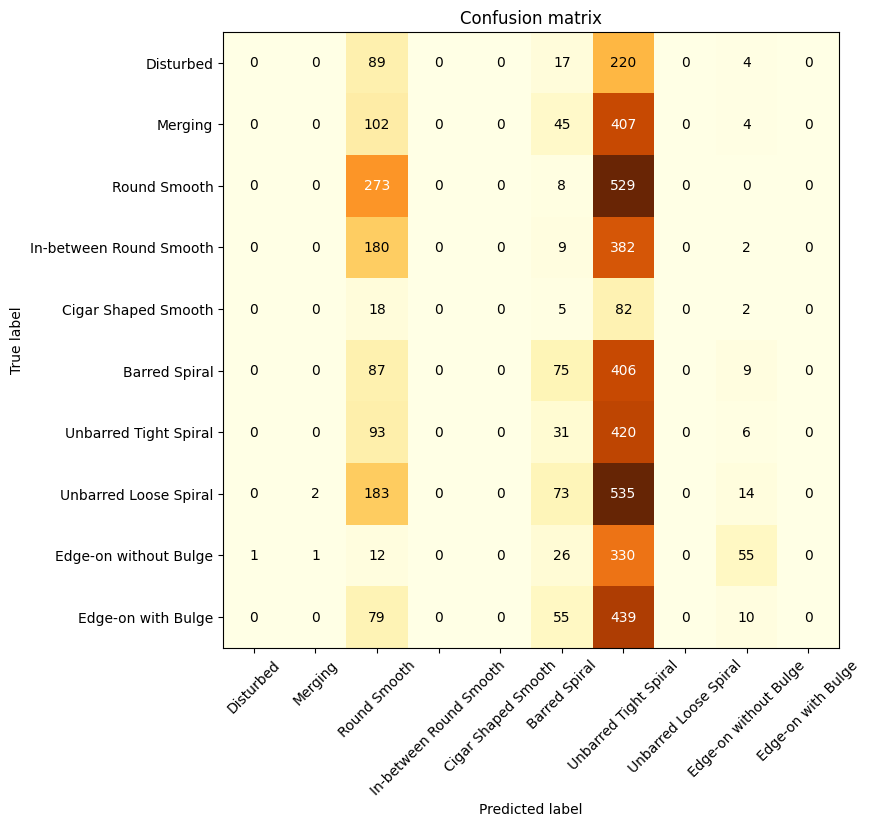

In [42]:
# *** Calcule l'accuracy et plot une matrice de confusion ***

test_acc = compute_accuracy(targets, predictions)
print(' [-] test acc. {:.6f}%'.format(test_acc * 100))

label_dict = {
    0: "Disturbed",
    1: "Merging",
    2: "Round Smooth",
    3: "In-between Round Smooth",
    4: "Cigar Shaped Smooth",
    5: "Barred Spiral",
    6: "Unbarred Tight Spiral",
    7: "Unbarred Loose Spiral",
    8: "Edge-on without Bulge",
    9: "Edge-on with Bulge"
}

labels = [label_dict[i] for i in range(len(label_dict))]

confusion_matrix = compute_confusion_matrix(targets, predictions, 10)
plot_confusion_matrix(confusion_matrix, labels, "Confusion matrix")

plt.show()